#Get data

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2021-09-16 18:03:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-16 18:03:45 (93.8 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-09-16 18:03:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.128, 108.177.120.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   190MB/s    in 9.0s    

2021-09-16 18:04:02 (172 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [5]:
# Make datasets
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Model overview

* ModelCheckpoint callback 
* Data augmentation layer
* Functional EfficientNetB0 with no top layers and custom output layer
* Compile model
* Feature extraction

##ModelCheckpoint callbacks

In [6]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

##Data augmentation

In [9]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential 

data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                         tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                         tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
                                         tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
                                         # no rescaling needed as we are using efficientnetb0
], name = 'data_augmentation')

##Creating a base_model

In [10]:
# Use EfficientNetB0 as base model and freeze its layers for feature extraction
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


##Make model

In [11]:
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) 
x = base_model(x, training=False) # training = False, so that we can use the pre trained weights of EfficientNetB0
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## Compile and Fit model. Feature extraction

In [14]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 155s 513ms/step - loss: 3.4963 - accuracy: 0.2422 - val_loss: 2.6030 - val_accuracy: 0.4420
Epoch 2/5
237/237 [==============================] - 98s 411ms/step - loss: 2.3496 - accuracy: 0.4636 - val_loss: 2.1186 - val_accuracy: 0.5111
Epoch 3/5
237/237 [==============================] - 86s 362ms/step - loss: 1.9831 - accuracy: 0.5251 - val_loss: 1.9744 - val_accuracy: 0.5207
Epoch 4/5
237/237 [==============================] - 78s 326ms/step - loss: 1.7783 - accuracy: 0.5719 - val_loss: 1.9143 - val_accuracy: 0.5281
Epoch 5/5
237/237 [==============================] - 76s 318ms/step - loss: 1.6101 - accuracy: 0.6017 - val_loss: 1.8643 - val_accuracy: 0.5289


In [15]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 103s 130ms/step - loss: 1.7249 - accuracy: 0.5530


[1.7248573303222656, 0.5530297160148621]

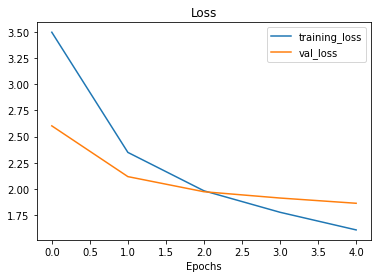

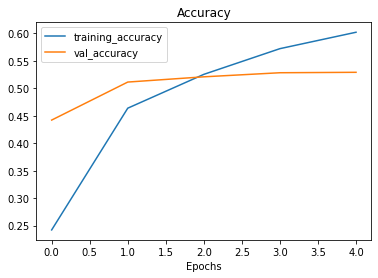

In [16]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [17]:
# Unfreeze layers of base model
base_model.trainable = True

# Freeze all layers except bottom 5. This is done so that we can train only the bottom 5 layers
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [18]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [20]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [21]:
# Fine-tune for next 5 epochs as we have already done 5 epochs during feature extraction
fine_tune_epochs = 10 

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start frm last epoch of prev model(feature extracted model)

Epoch 5/10
237/237 [==============================] - 88s 334ms/step - loss: 1.3533 - accuracy: 0.6490 - val_loss: 1.8557 - val_accuracy: 0.5199
Epoch 6/10
237/237 [==============================] - 69s 290ms/step - loss: 1.2249 - accuracy: 0.6738 - val_loss: 1.8767 - val_accuracy: 0.5199
Epoch 7/10
237/237 [==============================] - 70s 293ms/step - loss: 1.1639 - accuracy: 0.6943 - val_loss: 1.8388 - val_accuracy: 0.5262
Epoch 8/10
237/237 [==============================] - 70s 293ms/step - loss: 1.0782 - accuracy: 0.7116 - val_loss: 1.8591 - val_accuracy: 0.5267
Epoch 9/10
237/237 [==============================] - 67s 279ms/step - loss: 1.0323 - accuracy: 0.7286 - val_loss: 1.9034 - val_accuracy: 0.5164
Epoch 10/10
237/237 [==============================] - 67s 282ms/step - loss: 0.9698 - accuracy: 0.7372 - val_loss: 1.8445 - val_accuracy: 0.5302


In [22]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 102s 130ms/step - loss: 1.6223 - accuracy: 0.5756


[1.6223301887512207, 0.5756039619445801]

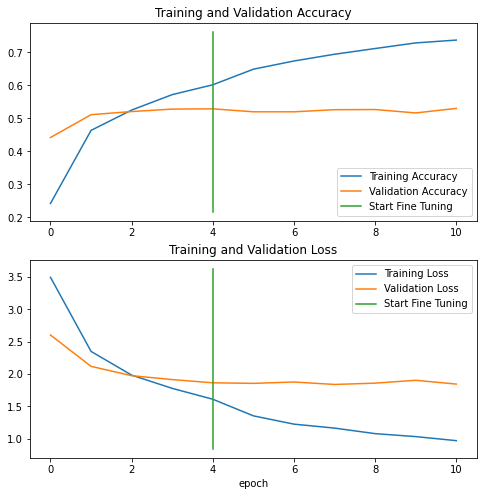

In [23]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading model

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Save fine-tuned model
model.save("/content/drive/MyDrive/ML/food_vision/dataset_20")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/dataset_20/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/ML/food_vision/dataset_20")

In [30]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 106s 132ms/step - loss: 1.6223 - accuracy: 0.5756


[1.6223301887512207, 0.5756039619445801]

In [31]:
# The results from our loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.6223301887512207, 0.5756039619445801]

## Evaluating the performance of model

In [ ]:
import tensorflow as tf

# Download pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-02-26 00:07:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   116MB/s    in 0.4s    

2021-02-26 00:07:03 (116 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load in saved model 
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 108s 127ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027207851409912, 0.6077623963356018]

### Making predictions with our trained model

In [32]:
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 92s 114ms/step


In [33]:
len(test_data)

790

In [34]:
len(preds_probs)

25250

In [35]:
len(test_data) * 32 # test_data is a batch_dataset. Since its divided into batches of size 32, multiplying no. of batches * batch_size gives total test_data

25280

In [36]:
preds_probs.shape

(25250, 101)

In [37]:
# probabiltites of 1st image of test_data
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([3.49794328e-01, 1.05602339e-04, 2.35680923e-01, 6.03889845e-08,
        3.28995634e-06, 2.55000509e-06, 2.04662181e-04, 2.09667214e-05,
        2.74679270e-02, 4.91580809e-04, 7.32004173e-06, 8.86767248e-06,
        2.21682852e-03, 6.92323908e-07, 2.78933961e-02, 9.50004149e-04,
        2.74426839e-05, 9.38127167e-04, 2.26079719e-03, 3.85766680e-06,
        1.83320706e-04, 6.64214676e-05, 4.53990593e-04, 4.46157414e-04,
        9.19398095e-04, 9.72337264e-04, 1.67427628e-04, 2.96538583e-05,
        9.92071554e-02, 8.30055028e-03, 1.30725334e-06, 2.01161442e-04,
        4.39012161e-04, 1.94972600e-07, 4.18530405e-03, 2.38524408e-05,
        7.58915849e-05, 9.74605326e-04, 1.93944052e-02, 1.11498575e-05,
        2.23717550e-04, 1.50472776e-03, 1.34825695e-03, 6.19984939e-06,
        2.32748916e-05, 4.14229507e-05, 3.03063169e-03, 3.78322991e-04,
        7.73554973e-07, 5.41646257e-02, 6.15271740e-04, 1.29745695e-05,
        4.44457866e-02, 1.03603816e-02, 2.14265474e-05, 5.411647

In [38]:
preds_probs[0].argmax()

0

In [39]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)# get indices of clmns having max value. do this for every row

# How do they look?
pred_classes[:10]

array([ 0,  0,  0,  8, 29, 78, 29, 46,  0,  0])

In [40]:
# How many pred classes do we have?
len(pred_classes)

25250

In [ ]:
test_data.class_names

In [42]:
test_data.class_names[preds_probs[0].argmax()]

'apple_pie'

In [43]:
# To get our test labels we need to unravel our test_data BatchDataset
# we have the predictions of test_images. we need to get the original test_labels

y_labels = []
for images, labels in test_data.unbatch():# To get our test labels we need to unravel our test_data BatchDataset
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [44]:
len(y_labels)

25250

In [45]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [46]:
len(test_data)

790

### Evaluating our model's predictions

One way to check that our model's predictions array (`pred_classes`) is in the same order as our test labels array (`y_labels`) is to find the accuracy score.

In [47]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.5756039603960396

In [48]:
class_names = test_data.class_names

### confusion matrix 

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

### classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), let's try it out.

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.37      0.11      0.17       250
           1       0.48      0.74      0.58       250
           2       0.56      0.59      0.57       250
           3       0.78      0.54      0.64       250
           4       0.49      0.45      0.47       250
           5       0.39      0.42      0.40       250
           6       0.78      0.71      0.74       250
           7       0.84      0.68      0.75       250
           8       0.22      0.57      0.31       250
           9       0.44      0.58      0.50       250
          10       0.39      0.50      0.44       250
          11       0.83      0.46      0.60       250
          12       0.76      0.56      0.65       250
          13       0.57      0.45      0.50       250
          14       0.41      0.60      0.48       250
          15       0.39      0.39      0.39       250
          16       0.70      0.44      0.54       250
          17       0.34    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [50]:
# make a dictionary of classification report so that we can plot it
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.1723076923076923,
  'precision': 0.37333333333333335,
  'recall': 0.112,
  'support': 250},
 '1': {'f1-score': 0.5777080062794347,
  'precision': 0.4754521963824289,
  'recall': 0.736,
  'support': 250},
 '10': {'f1-score': 0.43749999999999994,
  'precision': 0.38650306748466257,
  'recall': 0.504,
  'support': 250},
 '100': {'f1-score': 0.6232394366197183,
  'precision': 0.5566037735849056,
  'recall': 0.708,
  'support': 250},
 '11': {'f1-score': 0.596401028277635,
  'precision': 0.8345323741007195,
  'recall': 0.464,
  'support': 250},
 '12': {'f1-score': 0.6451612903225807,
  'precision': 0.7608695652173914,
  'recall': 0.56,
  'support': 250},
 '13': {'f1-score': 0.5033407572383073,
  'precision': 0.5678391959798995,
  'recall': 0.452,
  'support': 250},
 '14': {'f1-score': 0.4829821717990275,
  'precision': 0.40599455040871935,
  'recall': 0.596,
  'support': 250},
 '15': {'f1-score': 0.39200000000000007,
  'precision': 0.392,
  'recall': 0.392,
  'support': 

In [51]:
class_names[59]

'lasagna'

In [52]:
classification_report_dict["60"]["f1-score"]

0.6666666666666666

In [53]:
# create a dictionary of only f1 scores as its the better overall metric for classification problems

class_f1_scores = {}

for k, v in classification_report_dict.items():
  if k == "accuracy":  # in the classification_report_dict, we only need items b4 accuracy as we only use f1-score
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"] # get index of class using int(k) (k is string). then for that index, the key 'class_name' would have value as that class's f1 score
class_f1_scores

{'apple_pie': 0.1723076923076923,
 'baby_back_ribs': 0.5777080062794347,
 'baklava': 0.57421875,
 'beef_carpaccio': 0.6398104265402843,
 'beef_tartare': 0.4666666666666667,
 'beet_salad': 0.40229885057471265,
 'beignets': 0.7421383647798742,
 'bibimbap': 0.7533039647577092,
 'bread_pudding': 0.3149779735682819,
 'breakfast_burrito': 0.4974271012006861,
 'bruschetta': 0.43749999999999994,
 'caesar_salad': 0.596401028277635,
 'cannoli': 0.6451612903225807,
 'caprese_salad': 0.5033407572383073,
 'carrot_cake': 0.4829821717990275,
 'ceviche': 0.39200000000000007,
 'cheese_plate': 0.5427872860635696,
 'cheesecake': 0.3906510851419032,
 'chicken_curry': 0.4658119658119658,
 'chicken_quesadilla': 0.5693069306930693,
 'chicken_wings': 0.6828358208955224,
 'chocolate_cake': 0.5535055350553505,
 'chocolate_mousse': 0.41044776119402987,
 'churros': 0.7111984282907662,
 'clam_chowder': 0.6575342465753425,
 'club_sandwich': 0.6729678638941399,
 'crab_cakes': 0.35955056179775285,
 'creme_brulee': 0.

In [54]:
# Turn f1-scores into df for plotting graph and sorting values
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [55]:
f1_scores[:10]

,class_names,f1-score
33,edamame,0.951456
63,macarons,0.872881
75,pho,0.823529
32,dumplings,0.814815
54,hot_and_sour_soup,0.812500
45,frozen_yogurt,0.811594
91,spaghetti_carbonara,0.811133
69,oysters,0.809422
64,miso_soup,0.807921
86,sashimi,0.805293


### Plotting graph of f1-score

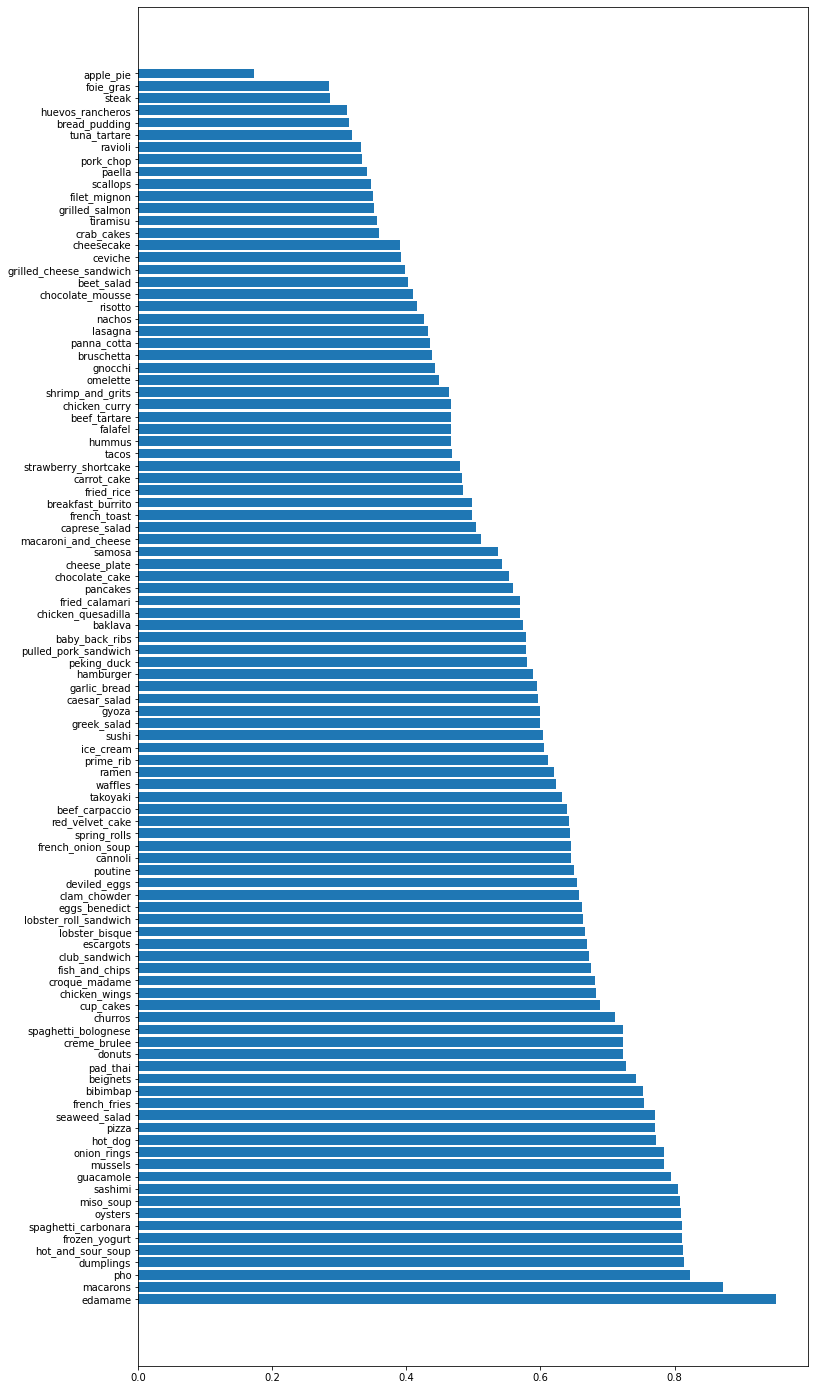

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,25))
ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names']);

### Visualizing predictions on test images

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images. Steps-
* Read in image filepath
* Turn the image into a Tensor
* Resize the image tensor to be the same size as the images our model has trained on.
* Scale the image to get all of the pixel values between 0 & 1

####Making a func for loading and preparing images

In [59]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not
  
  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  else:
    return img

In [60]:
train_data_all_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

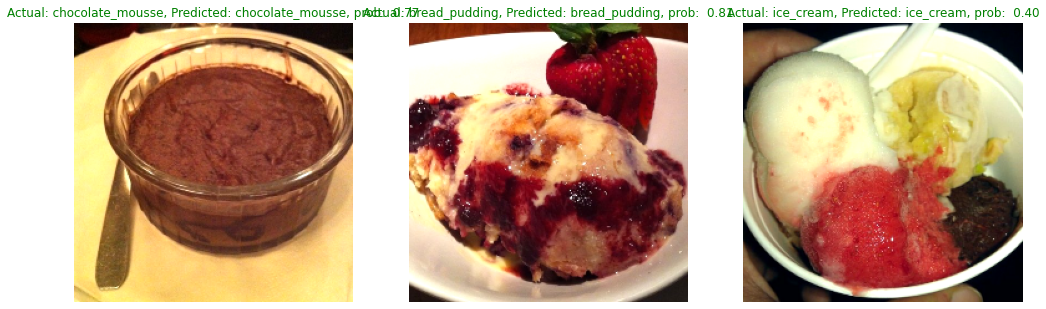

In [65]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # choose any random image using its class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name)) # os.listdir - lists all sub-directories in given directory.
  # it would return filename of any random image of class 'class_name'
  filepath = test_dir + class_name + "/" + filename
  
  # Load image
  img = load_and_prep_image(filepath, scale=False) # img is of the shape (224, 224, 3)
  img_expanded = tf.expand_dims(img, axis=0) # but test_data, train_data are in shape (None, 224, 224 ,3). So we have to expand dimension
  
  #get probability
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()] 

  plt.subplot(1, 3, i+1) # 3 subplots for each image
  plt.imshow(img/225.) 
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f'Actual: {class_name}, Predicted: {pred_class}, prob: {pred_prob.max(): .2f}', c = title_color)
  plt.axis(False);

### Finding the most wrong predictions
Steps
1. Get file paths of all images in the test dataset
2. Create a DataFrame of the image filepaths, test class labels, predicted classes, max prediction probabilities, prediction class names, test class names.
3. Find predictions where test label doesn't match the prediction
4. Sort based on wrong predictions
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

#### 1. Get file paths of all images in the test dataset

---



In [66]:
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",# /*/* means every directory in test and every image in that directory
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

#### 2.Create a DataFrame of the image filepaths, test class labels, predicted classes, max prediction probabilities, prediction class names, test class names.

In [67]:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels], # ith elem in y_labels contains the index of its class in class_name. so for every elem in y_label, we get the index of its class and use it for getting the class_name 
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.349794,apple_pie,apple_pie
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.881154,apple_pie,apple_pie
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.414566,apple_pie,apple_pie
3,b'/content/101_food_classes_10_percent/test/ap...,0,8,0.231380,apple_pie,bread_pudding
4,b'/content/101_food_classes_10_percent/test/ap...,0,29,0.365247,apple_pie,cup_cakes
...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.980361,waffles,waffles
25246,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.569342,waffles,waffles
25247,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.489842,waffles,waffles
25248,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.325991,waffles,waffles


#### 3.Find predictions where test label doesn't match the prediction

In [68]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.349794,apple_pie,apple_pie,True
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.881154,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.414566,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,8,0.231380,apple_pie,bread_pudding,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,29,0.365247,apple_pie,cup_cakes,False


#### 4.Sort based on wrong predictions

In [69]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
# pred_df[pred_df["pred_correct"] == False] - get all those rows having pred_correct as False
# then sort the result in desc acc to pred_conf and get the top 100 rows frm the new resultant table

top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
23631,b'/content/101_food_classes_10_percent/test/st...,94,83,0.999585,strawberry_shortcake,red_velvet_cake,False
23797,b'/content/101_food_classes_10_percent/test/su...,95,86,0.999289,sushi,sashimi,False
15826,b'/content/101_food_classes_10_percent/test/ma...,63,29,0.997766,macarons,cup_cakes,False
18001,b'/content/101_food_classes_10_percent/test/pa...,72,67,0.997042,pancakes,omelette,False
22511,b'/content/101_food_classes_10_percent/test/sp...,90,78,0.996153,spaghetti_bolognese,poutine,False
23886,b'/content/101_food_classes_10_percent/test/su...,95,10,0.994794,sushi,bruschetta,False
21216,b'/content/101_food_classes_10_percent/test/ri...,84,70,0.994593,risotto,pad_thai,False
22203,b'/content/101_food_classes_10_percent/test/se...,88,51,0.994051,seaweed_salad,guacamole,False
21810,b'/content/101_food_classes_10_percent/test/sc...,87,29,0.994042,scallops,cup_cakes,False
11642,b'/content/101_food_classes_10_percent/test/ga...,46,10,0.993813,garlic_bread,bruschetta,False


#### 5.Visualize the images with the highest prediction probabilities but have the wrong prediction.

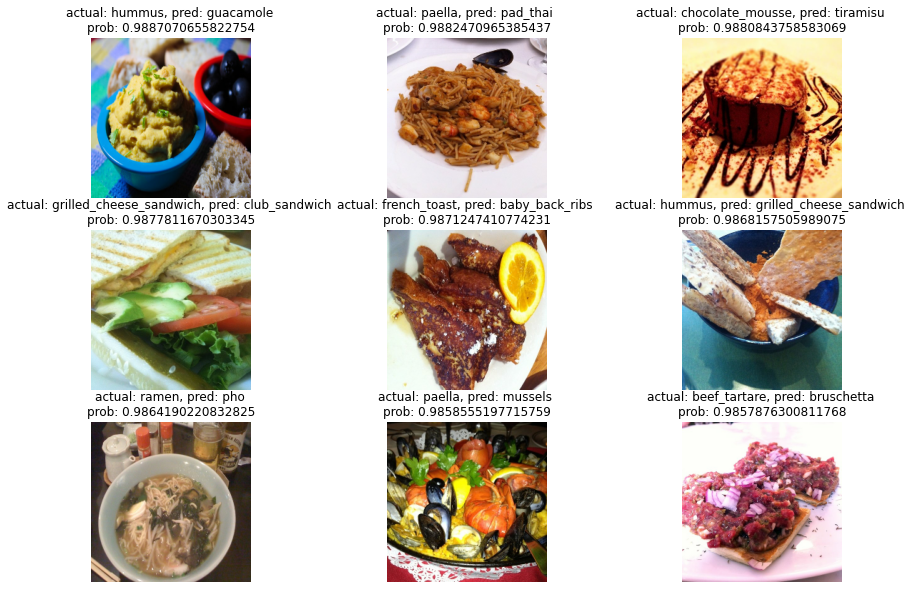

In [70]:
images_to_view = 9
start_index = 20
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row

  # pred_prob = row[4]
  # y_true_class = row[5]
  # y_pred_class = row[6]
  # we can use these 3 instead of the _, _, thing to get data from row
  
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
  plt.axis(False)

### Test out the big dog model on our own custom images

In [71]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2021-09-16 19:28:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  41.2MB/s    in 0.3s    

2021-09-16 19:28:37 (41.2 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [72]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/pizza-dad.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/chicken_wings.jpeg']

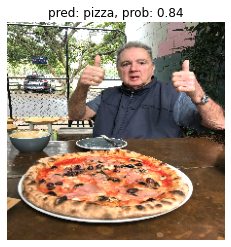

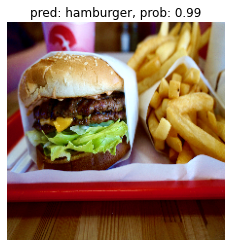

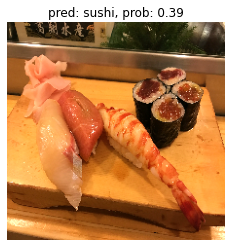

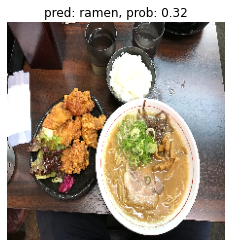

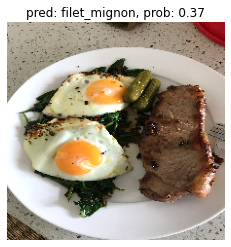

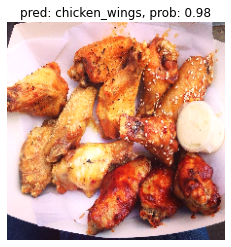

In [73]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with the highet prediction probability
  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/225.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

See full course materials (including exercises and extra-curriculum on GitHub): https://github.com/mrdbourke/tensorflow-deep-learning